In [ ]:
import numpy as np
import pandas as pd

import nltk
nltk.download('all')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords,words

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier, XGBRegressor

from random import uniform, randint

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

In [ ]:
import urllib.request
import gzip
import json

# set the URL of the raw JSON file on GitHub
url = "https://github.com/zohairhashmi/amazon-sentiment-analysis/blob/main/AMAZON_FASHION_sample.json.gz?raw=true"

# download the file and read its contents
with urllib.request.urlopen(url) as response:
    with gzip.GzipFile(fileobj=response) as uncompressed:
        json_data = json.load(uncompressed)

reviews = pd.DataFrame(json_data)

print(reviews.shape)
reviews.head()

(220909, 12)


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,vote,image
0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,3.0,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN
2,3.0,True,"07 17, 2013",AHWOW7D1ABO9C,B00007GDFV,rosieO,"Item is of good quality. Looks great, too. But...",Buxton heiress collection,1374019200,{'Color:': ' Black'},NaN,NaN
3,1.0,True,"01 4, 2013",A1G3S57JGZNPCL,B00007GDFV,kimberly a schotthoefer,"cheap and cheesy, but i guess i could have exp...",inexpensive case,1357257600,{'Color:': ' Black'},NaN,NaN
4,5.0,True,"10 24, 2017",A1NSKPSR0XZ0C9,B00007GDFV,Jules,I love it it is just what I was looking for th...,Perfect just what I was looking for!,1508803200,{'Color:': ' Black'},NaN,NaN


In [ ]:
#converting overall column to integer
reviews['overall'] = reviews['overall'].astype(int)
reviews.rename(columns={'overall': 'rating'}, inplace=True)

#selecting only the columns we need
reviews = reviews[['reviewText', 'rating']]

#clean the data by removing null values
reviews.dropna(inplace=True)
print("After pre-processing & cleaing: ", reviews.shape)

#add column for sentiment analysis
reviews['sentiment'] = np.where(reviews['rating'] == 5, 1, 
                                       np.where(reviews['rating'] == 4, 1, 0))

reviews.head()

After pre-processing & cleaing:  (220597, 2)


/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
<ipython-input-3-e37cf6530ecd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['sentiment'] = np.where(reviews['rating'] == 5, 1,


,reviewText,rating,sentiment
0,Exactly what I needed.,5,1
1,Okay,3,0
2,"Item is of good quality. Looks great, too. But...",3,0
3,"cheap and cheesy, but i guess i could have exp...",1,0
4,I love it it is just what I was looking for th...,5,1


In [ ]:
# randomly sample 5000 rows from the dataframe using stratified sampling based on sentiment
reviews_sample = reviews.groupby('sentiment').apply(lambda x: x.sample(n=5000, random_state=1)).reset_index(drop=True)

print("Size of sample: ",reviews_sample.shape[0])
print("Sentiment wise distribution of sample:") 
print(reviews_sample['sentiment'].value_counts())

Size of sample:  10000
Sentiment wise distribution of sample:
0    5000
1    5000
Name: sentiment, dtype: int64


In [ ]:
#convert reviewText to lower case
reviews_sample['reviewText'] = reviews_sample['reviewText'].str.lower()
#remove punctuation from summary and reviewText
reviews_sample['reviewText'] = reviews_sample['reviewText'].str.replace('[^\w\s]',' ')
#remove other characters from reviewText
reviews_sample['reviewText'] = reviews_sample['reviewText'].str.replace(r'[^a-zA-Z\s]', ' ')
#remove numbers from reviewText
reviews_sample['reviewText'] = reviews_sample['reviewText'].str.replace('\d+', ' ')
# remove words not present in English dictionary
english_words = set(words.words())  # create a set of English words
reviews_sample['reviewText'] = reviews_sample['reviewText'].apply(lambda x: ' '.join(word for word in x.split() if word in english_words))
#remove stop words from summary and reviewText
"""
Stop words are basically a set of commonly used words in any language.
They are words that are so common that they are not useful in the context of a search.
"""
stop = stopwords.words('english')
reviews_sample['reviewText'] = reviews_sample['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
#remove words not in the english dictionary
reviews_sample['reviewText'] = reviews_sample['reviewText'].apply(lambda x: " ".join(x for x in x.split() if len(x) > 2))

#remove rare words from summary and reviewText
rare = pd.Series(' '.join(reviews_sample['reviewText']).split()).value_counts() != 2
rare = rare[rare == False]
reviews_sample['reviewText'] = reviews_sample['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in rare))

<ipython-input-5-c24ab5de5347>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews_sample['reviewText'] = reviews_sample['reviewText'].str.replace('[^\w\s]',' ')
<ipython-input-5-c24ab5de5347>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews_sample['reviewText'] = reviews_sample['reviewText'].str.replace(r'[^a-zA-Z\s]', ' ')
<ipython-input-5-c24ab5de5347>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews_sample['reviewText'] = reviews_sample['reviewText'].str.replace('\d+', ' ')


In [ ]:
#lemmatize reviewText to get the root word
"""
Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item.
"""
lemmatizer = WordNetLemmatizer()
reviews_sample['reviewText'] = reviews_sample['reviewText'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

#reset index
reviews_sample.reset_index(drop=True, inplace=True)

print("DataFrame shape: ", reviews_sample.shape)
reviews_sample.head()

DataFrame shape:  (10000, 3)


,reviewText,rating,sentiment
0,like went extra size per year old play dress,1,0
1,bought fit eight year old thick matter neither...,1,0
2,sized due daughter bought perfect favorite shi...,1,0
3,disappointing poor finish,1,0
4,said medium size definitely large disappointed...,3,0


In [ ]:
response_3 = pd.Series(' '.join(reviews_sample[reviews_sample['rating'] == 3]['reviewText']).split()).value_counts()[:10]
response_3

size      454
small     393
like      376
fit       295
would     262
wear      248
nice      231
cute      206
good      206
little    200
dtype: int64

In [ ]:
freq_pos = pd.Series(' '.join(reviews_sample[reviews_sample['sentiment'] == 1]['reviewText']).split()).value_counts()[:10]
freq_neg = pd.Series(' '.join(reviews_sample[reviews_sample['sentiment'] == 0]['reviewText']).split()).value_counts()[:10]

freq_pos, freq_neg

(great      1191
 love       1157
 fit         818
 size        766
 like        658
 good        644
 nice        582
 well        571
 wear        544
 perfect     525
 dtype: int64, small       1228
 like        1170
 size        1142
 fit          829
 would        688
 one          575
 wear         573
 ordered      490
 material     472
 way          461
 dtype: int64)

In [ ]:
#vectorize the text using TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True)
X_tfidf = vectorizer.fit_transform(reviews_sample['reviewText'])

X_tfidf = X_tfidf.astype('float32')
X_tfidf = X_tfidf.todense()
X_tfidf = pd.DataFrame(X_tfidf)
# X_tfidf = X_tfidf.rename(columns=dict(zip(X_tfidf.columns.to_list(),vectorizer.get_feature_names())))

print(X_tfidf.shape)

(10000, 4638)


In [ ]:
X_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,4628,4629,4630,4631,4632,4633,4634,4635,4636,4637
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# concatenate the reviewText dataframe with the instruments_df dataframe and drop the reviewText column
X_vec = pd.concat([reviews_sample, X_tfidf], axis=1)
X_vec.drop(['rating','reviewText'], axis=1, inplace=True)
X_vec.head()

,sentiment,0,1,2,3,4,5,6,7,8,...,4628,4629,4630,4631,4632,4633,4634,4635,4636,4637
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Split into training and test data

In [ ]:
#split the data into training and testing sets
X = X_vec.drop(['sentiment'], axis=1)
y = X_vec['sentiment']

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print("X_train.shape: ", X_train.shape)
print("X_test.shape: ", X_test.shape)


X_train.shape:  (8000, 4638)
X_test.shape:  (2000, 4638)


### Support Vector Classification

In [ ]:
#Support Vector Classifier
svr_lin = SVC()
param_grid = {'C': list(np.linspace(0,2,5))}
grid = GridSearchCV(svr_lin, param_grid, cv=5, scoring='f1_weighted')

#fit the model
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py", line 315, in _dense_fit
    ) = libsvm.fit(
  File "sklearn/svm/_libsvm.pyx", line 189, in skle

{'C': 1.0}
0.8335595847437649
SVC()


In [ ]:
# Support Vector Classifier model
svr_lin = LinearSVC(multi_class='ovr', C=grid.best_params_['C'], loss='squared_hinge', dual=False)
svr_lin.fit(X_train, y_train)

# Predict using training and testing data and display the accuracy, f-1 score, precision for Positive and Negative Sentiment Classifiers 
svr_lin_predictions = svr_lin.predict(X_test)
report = classification_report(y_test, svr_lin_predictions, output_dict=True)
data_report = pd.DataFrame(report).transpose().round(2)
cm = sns.light_palette("yellow", as_cmap=True)
data_report.style.background_gradient(cmap=cm)

,precision,recall,f1-score,support
0,0.810000,0.810000,0.810000,1000.000000
1,0.810000,0.810000,0.810000,1000.000000
accuracy,0.810000,0.810000,0.810000,0.810000
macro avg,0.810000,0.810000,0.810000,2000.000000
weighted avg,0.810000,0.810000,0.810000,2000.000000


Accuracy:  0.809
Precision:  0.8096192384769539
Recall:  0.808
F1-Score:  0.8088088088088088


Text(0.5, 1.0, 'Accuracy Score: 0.809')

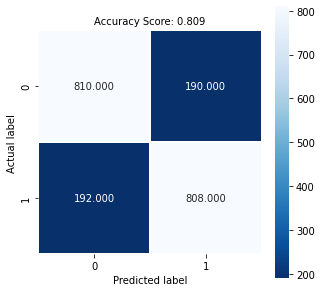

In [ ]:
from sklearn.metrics import confusion_matrix

#calculate the accuracy, precision, recall and f1-score
print("Accuracy: ", accuracy_score(y_test, svr_lin_predictions))
print("Precision: ", precision_score(y_test, svr_lin_predictions))
print("Recall: ", recall_score(y_test, svr_lin_predictions))
print("F1-Score: ", f1_score(y_test, svr_lin_predictions))

#print confusion matrix
confusion_matrix(y_test, svr_lin_predictions)

#plot the confusion matrix
cm = confusion_matrix(y_test, svr_lin_predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, svr_lin_predictions))
plt.title(all_sample_title, size = 10)

### Logistic Regression

In [ ]:
#Grid Search using Logisitic Regression
log_reg = LogisticRegression(max_iter = 1000)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]} #Regularization parameter
logreg_grid = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1_weighted')

#fit the model
logreg_grid.fit(X_train, y_train)

print(logreg_grid.best_params_)
print(logreg_grid.best_score_)

{'C': 1}
0.8316108667509884


In [ ]:
# Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, C = logreg_grid.best_params_['C'])
log_reg.fit(X_train, y_train)

# Predict using training and testing data and display the accuracy, f-1 score, precision for Positive and Negative Sentiment Classifiers 
log_reg_predictions = log_reg.predict(X_test)
report = classification_report(y_test,log_reg_predictions, output_dict=True)
data_report = pd.DataFrame(report).transpose().round(2)
cm = sns.light_palette("yellow", as_cmap=True)
data_report.style.background_gradient(cmap=cm)

,precision,recall,f1-score,support
0,0.820000,0.820000,0.820000,1000.000000
1,0.820000,0.820000,0.820000,1000.000000
accuracy,0.820000,0.820000,0.820000,0.820000
macro avg,0.820000,0.820000,0.820000,2000.000000
weighted avg,0.820000,0.820000,0.820000,2000.000000


Accuracy:  0.8225
Precision:  0.8228228228228228
Recall:  0.822
F1-Score:  0.8224112056028013


Text(0.5, 1.0, 'Accuracy Score: 0.8225')

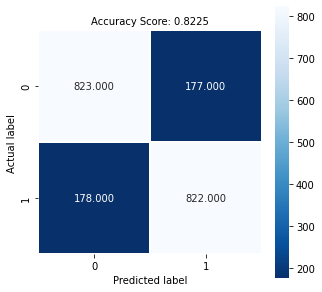

In [ ]:
from sklearn.metrics import confusion_matrix

#calculate the accuracy, precision, recall and f1-score
print("Accuracy: ", accuracy_score(y_test, log_reg_predictions))
print("Precision: ", precision_score(y_test, log_reg_predictions))
print("Recall: ", recall_score(y_test, log_reg_predictions))
print("F1-Score: ", f1_score(y_test, log_reg_predictions))

#print confusion matrix
confusion_matrix(y_test, log_reg_predictions)

#plot the confusion matrix
cm = confusion_matrix(y_test, log_reg_predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, log_reg_predictions))
plt.title(all_sample_title, size = 10)

### Random Forest Classifier

In [ ]:
# Random Forect Classifier Model
RndFst = RandomForestClassifier()
param_grid = {'criterion' : ["gini", "entropy", "log_loss"]}
grid = GridSearchCV(RndFst, param_grid, cv=5, scoring='f1_weighted')

#fit the model
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", lin

{'criterion': 'entropy'}
0.8212143264630768


In [ ]:
# Logistic Regression model
rnd_frst = RandomForestClassifier(criterion = grid.best_params_['criterion'])
rnd_frst.fit(X_train, y_train)

# Predict using training and testing data and display the accuracy, f-1 score, precision for Positive and Negative Sentiment Classifiers 
rnd_frst_predictions = rnd_frst.predict(X_test)
report = classification_report(y_test,rnd_frst_predictions, output_dict=True)
data_report = pd.DataFrame(report).transpose().round(2)
cm = sns.light_palette("yellow", as_cmap=True)
data_report.style.background_gradient(cmap=cm)

,precision,recall,f1-score,support
0,0.810000,0.820000,0.810000,1000.000000
1,0.820000,0.810000,0.810000,1000.000000
accuracy,0.810000,0.810000,0.810000,0.810000
macro avg,0.810000,0.810000,0.810000,2000.000000
weighted avg,0.810000,0.810000,0.810000,2000.000000


Accuracy:  0.8125
Precision:  0.8159757330637007
Recall:  0.807
F1 Score:  0.8124943279534207
[[818 182]
 [193 807]]


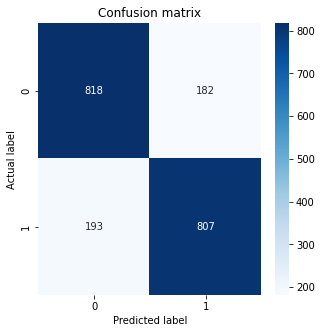

In [ ]:
from sklearn.metrics import confusion_matrix

#calculate the accuracy, precision, recall and f1-score
print('Accuracy: ', accuracy_score(y_test, rnd_frst_predictions))
print('Precision: ', precision_score(y_test, rnd_frst_predictions))
print('Recall: ', recall_score(y_test, rnd_frst_predictions))
print('F1 Score: ', f1_score(y_test, rnd_frst_predictions, average='weighted'))

#print confusion matrix
print(confusion_matrix(y_test, rnd_frst_predictions))

#plot the confusion matrix
cm = confusion_matrix(y_test, rnd_frst_predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="g", cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')
plt.show()

### Naive Bayes Classifier

In [ ]:
# Naive Bayes Classifier Model
NB = MultinomialNB()
param_grid = {'alpha' : np.linspace(0.01, 0.05, 9)}
nb_grid = GridSearchCV(NB, param_grid, cv=5, scoring='f1_weighted')

#fit the model
nb_grid.fit(X_train, y_train)

print(nb_grid.best_params_)
print(nb_grid.best_score_)

{'alpha': 0.05}
0.8052314932320573


In [ ]:
# Naive Bayes Classifier model
nb = MultinomialNB(alpha = nb_grid.best_params_['alpha'])
nb.fit(X_train, y_train)

# Predict using training and testing data and display the accuracy, f-1 score, precision for Positive and Negative Sentiment Classifiers
nb_predictions = nb.predict(X_test)
report = classification_report(y_test, nb_predictions, output_dict=True)
data_report = pd.DataFrame(report).transpose().round(2)
cm = sns.light_palette("yellow", as_cmap=True)

data_report.style.background_gradient(cmap=cm)

,precision,recall,f1-score,support
0,0.800000,0.800000,0.800000,1000.000000
1,0.800000,0.800000,0.800000,1000.000000
accuracy,0.800000,0.800000,0.800000,0.800000
macro avg,0.800000,0.800000,0.800000,2000.000000
weighted avg,0.800000,0.800000,0.800000,2000.000000


Accuracy:  0.8
Precision:  0.8024193548387096
Recall:  0.796
F1 Score:  0.7999967999487992
[[804 196]
 [204 796]]


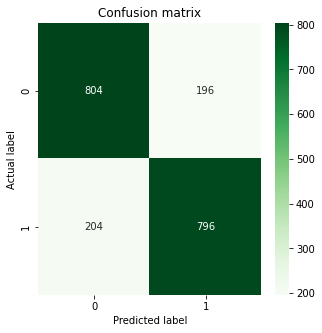

In [ ]:
from sklearn.metrics import confusion_matrix

#calculate the accuracy, precision, recall and f1-score
print('Accuracy: ', accuracy_score(y_test, nb_predictions))
print('Precision: ', precision_score(y_test, nb_predictions))
print('Recall: ', recall_score(y_test, nb_predictions))
print('F1 Score: ', f1_score(y_test, nb_predictions, average='weighted'))

#print confusion matrix
print(confusion_matrix(y_test, nb_predictions))

#plot the confusion matrix
cm = confusion_matrix(y_test, nb_predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="g", cmap='Greens')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')
plt.show()

### XGBoost Classifier

In [ ]:
# Naive Bayes Classifier Model
NB = MultinomialNB()
param_grid = {'alpha' : np.linspace(0.01, 0.05, 9)}
nb_grid = GridSearchCV(NB, param_grid, cv=5, scoring='f1_weighted')

# xgboost Classifier Model using the best threshold
xgb = XGBClassifier()
param_grid = {'learning_rate': [0.2,0.4,0.6,0.8,1.0]}
grid_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring='f1_weighted')

#fit the model
grid_xgb.fit(X_train, y_train)

print(grid_xgb.best_params_)
print(grid_xgb.best_score_)

In [ ]:
# XGBoost Classifier model using best threshold and learning rate
xgb = XGBClassifier(learning_rate = grid_xgb.best_params_['learning_rate'])

xgb.fit(X_train, y_train)

# Predict using training and testing data and display the accuracy, f-1 score, precision for Positive and Negative Sentiment Classifiers 
xgb_predictions = xgb.predict(X_test)
report = classification_report(y_test, xgb_predictions, output_dict=True)
data_report = pd.DataFrame(report).transpose().round(2)
cm = sns.light_palette("yellow", as_cmap=True)
data_report.style.background_gradient(cmap=cm)

In [ ]:
from sklearn.metrics import confusion_matrix

#calculate the accuracy, precision, recall and f1-score
print('Accuracy: ', accuracy_score(y_test, xgb_predictions))
print('Precision: ', precision_score(y_test, xgb_predictions))
print('Recall: ', recall_score(y_test, xgb_predictions))
print('F1 Score: ', f1_score(y_test, xgb_predictions, average='weighted'))

#print confusion matrix
print(confusion_matrix(y_test, xgb_predictions))

#plot the confusion matrix
cm = confusion_matrix(y_test, xgb_predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="g", cmap='Reds')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')
plt.show()